# Design of experiments
This tutorial is about the statistical considerations related to fMRI experimental design. Make sure you do the other lab (`06_GLM_part3_inference.ipynb`) first!

The tutorial is based on the online textbook here: hhttps://lukas-snoek.com/NI-edu/fMRI-introduction/week_3/design_of_experiments.html


Experimental designs for fMRI studies come in different flavors, depending on what hypotheses you have about the phenomenon of interest and how you manipulate this. Apart from the different types of experimental designs (e.g., subtractive, factorial, parametric), there are a couple of general recommendations w.r.t. experimental design that can optimize the chance of finding positive results, which will be discussed in this notebook as well. These recommendations have to do with the specific ordering and timing of the events in your experiment. For example, suppose you show images of cats (condition: "C") and dogs (condition: "D") to subjects in the scanner, and you're interested if the brain responds differently to images of dogs compared to images of cats. What ordering ("CCCCDDDD" or "CDCDCDCD" or "CCDCDDCD"?) and timing (how long should I wait to present another stimulus?) of the stimuli will yield the best (here: highest) effect possible, and why? 

**What you'll learn**: after this lab, you'll ...

- understand what 'design variance' is and how it relates to 'efficiency'
- understand the effect of design variance *t*-values
- know how to calculate design variance in Python

In [5]:
# First some imports
import os
import pip
os.system('python3 -m pip install numpy')
os.system('python3 -m pip install matplotlib')
os.system('python3 -m pip install scipy')
os.system('python3 -m pip install nilearn')

import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from nilearn.glm.first_level.hemodynamic_models import glover_hrf, glover_time_derivative
from scipy.stats import pearsonr

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 11.6 MB/s eta 0:00:00

[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: pip install --upgrade pip


/home/coder/.local/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


## Types of designs: factorial and parametric designs
In the previous tutorial ('the GLM: part 2'), we discussed contrasts at length and how to use contrast-vectors to specify simple hypotheses (e.g., happy faces > sad faces). The contrast-vectors from last week's lab were examples of either simple contrasts-against-baseline ($H_{0}: \beta = 0$) or examples of *subtractive designs* (also called categorical designs; e.g., $H_{0}: \beta_{1} - \beta_{2} = 0$). There are, however, more types of designs possible, like *factorial* and *parametric* designs. In this first section, we'll discuss these two designs shortly and have you implement GLMs to test hypotheses forwarded by these designs.

### Factorial designs
Factorial designs are designs in which each event (e.g., stimulus) may be represented by a combination of different conditions. For example, you could show images of squares and circles (condition 1: shape) which may be either green or red (condition 2: color). See the image below for a visualization of these conditions and the associated contrasts.

![](https://docs.google.com/drawings/d/e/2PACX-1vROtTEQm-rUlrDMJWlUwmbMVkjhDHrs9snSAPL4K86CtOKpd3EFZz-z4lWVEXeS6qnaZeFCqwCO9C90/pub?w=1120&h=527)

Before we'll explain this figure in more detail, let's generate some data. We will use the function below to do that. Please run it to initialize the function, but only spent time on the details, if you cannot help yourself.

In [6]:
from nilearn.glm.first_level.hemodynamic_models import glover_hrf, glover_time_derivative
from scipy.interpolate import interp1d

def simulate_signal(onsets, conditions, TR=2, duration=None, icept=0, params_canon=None, params_tderiv=None,
                    params_deriv1=None, phi=None, std_noise=1, osf=100, rnd_seed=None, plot=True):
    """ Simulates a somewhat realistic voxel signal with an associated design matrix. """
    if rnd_seed is not None:
        np.random.seed(rnd_seed)
    
    conds = sorted(np.unique(conditions))
    P = len(conds)
    
    if duration is None:
        duration = np.max(onsets) + 30
    
    if params_canon is None:
        params_canon = np.zeros(P)

    # TMP FIX
    params_tderiv = params_deriv1
    
    if params_tderiv is None:
        params_tderiv = np.zeros(P)

    X = np.zeros((duration * osf, P))
    for ons, con in zip(onsets, conditions):
        X[int(ons * osf), conds.index(con)] = 1
        
    hrf = glover_hrf(tr=1, oversampling=osf)
    hrf_d = glover_time_derivative(tr=1, oversampling=osf)

    t_orig = np.arange(0, duration, 1 / osf)
    t_new = np.arange(0, duration, TR)
    
    Xconv = np.zeros((t_orig.size, P * 2))
    idx = 0
    for i, this_hrf in enumerate([hrf, hrf_d]):
        this_hrf /= this_hrf.max()
        for ii in range(P):
            Xconv[:, idx] = np.convolve(X[:, ii], this_hrf)[:t_orig.size]  
            idx += 1
    
    Xconv = np.c_[np.ones(Xconv.shape[0]), Xconv]
    params = np.r_[icept, params_canon, params_tderiv]
    y = Xconv @ params
    
    resampler = interp1d(t_orig, y)
    y = resampler(t_new)       
    
    if phi is None:
        noise_cov = std_noise ** 2 * np.eye(y.size)
    else:
        noise_cov = std_noise ** 2 * phi ** toeplitz(np.arange(y.size))
    
    y = y + np.random.multivariate_normal(np.zeros(y.size), noise_cov)

    Xconv_ds = np.zeros((t_new.size, Xconv.shape[1]))
    for i in range(Xconv.shape[1]):
        resampler = interp1d(t_orig, Xconv[:, i])
        Xconv_ds[:, i] = resampler(t_new)
    
    est_betas = np.linalg.lstsq(Xconv_ds, y, rcond=None)[0]
    if plot:
        plt.figure(figsize=(15, 5))
        plt.plot(y)
        plt.plot(Xconv_ds @ est_betas)
        plt.xlim(0, y.size)
        plt.legend(['y', 'y-hat'])
        plt.show()

    return y, Xconv_ds

We'll assume that the TR is 1 second and that all onsets are always syncronized with the TR (so there won't be onsets at, e.g., 10.295 seconds). This way, we can ignore the downsampling issue. We'll convolve the data with an HRF already and plot the design matrix below:

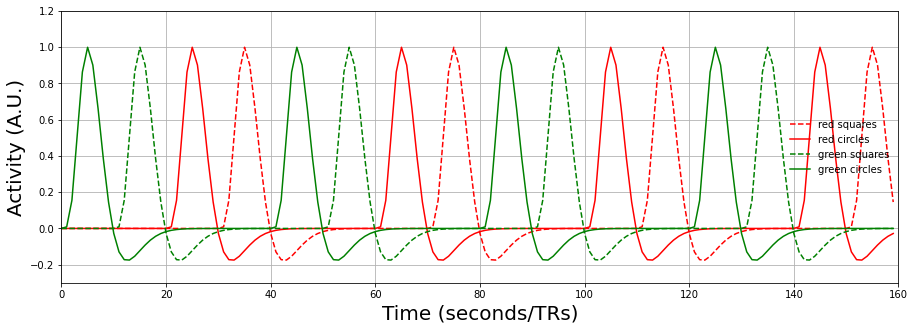

In [7]:

exp_length = 160
TR = 1
xmax = exp_length // TR

#Use the function specified above to simulate data
y, X = simulate_signal(
    onsets=np.array(
        [0, 40, 80, 120,  # red squares
         10, 50, 90, 130,  # red circles
         20, 60, 100, 140,  # green squares
         30, 70, 110, 150]  # green circles
    ),
    conditions=['rq'] * 4 + ['rc'] * 4 + ['gs'] * 4 + ['gc'] * 4,
    TR=TR,
    duration=exp_length,
    icept=0,
    params_canon=[1, 2, 3, 4],
    rnd_seed=42,
    plot=False
)

X = X[:, :5]

plt.figure(figsize=(15, 5))
plt.plot(X[:, 1], c='r', ls='--')
plt.plot(X[:, 2], c='r')
plt.plot(X[:, 3], c='g', ls='--')
plt.plot(X[:, 4], c='g')
plt.xlim(0, xmax)
plt.ylim(-0.3, 1.2)
plt.xlabel('Time (seconds/TRs)', fontsize=20)
plt.ylabel('Activity (A.U.)', fontsize=20)
plt.legend(['red squares', 'red circles', 'green squares', 'green circles'], frameon=False)
plt.grid()
plt.show()

We have also the time series of a (hypothetical) fMRI voxel, loaded and plotted below:

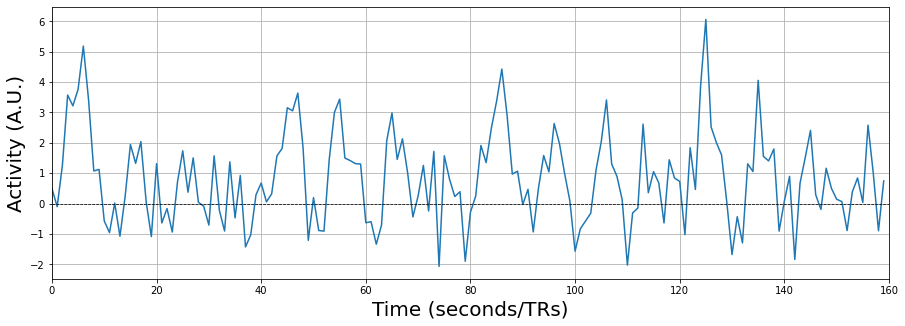

In [8]:
plt.figure(figsize=(15, 5))
plt.plot(y)
plt.xlim(0, xmax)
plt.axhline(0, ls='--', c='k', lw=0.75)
plt.xlabel('Time (seconds/TRs)', fontsize=20)
plt.ylabel('Activity (A.U.)', fontsize=20)
plt.grid()
plt.show()

<div class='alert alert-warning'>
    <b>ToDo1</b>: Time to refresh your memory on how to implement the GLM! Run linear regression with the design specified above (i.e., the <tt>X</tt> variable). Store the resulting parameters (i.e., the "betas") in a new variable named <tt>betas_todo</tt>. Check whether the design already includes an intercept!
</div>

In [11]:
from numpy.linalg import inv

### BEGIN SOLUTION
betas_todo = inv(X.T @ X) @ X.T @ y
betas_todo

### END SOLUTION

array([-0.08449338,  1.04387084,  2.07922769,  2.8557658 ,  4.20616653])

Alright, now, from the figure above, you can see there are many different contrast possible! First of all, we can test for *main effects*: these are effects of a single condition, collapsing over the other(s). For example, testing whether red stimuli lead to different activity levels than green stimuli (regardless of shape) would be a test of a main effect. Technically, main effects within factorial designs are tested with F-tests, which are undirectional tests, which mean that they test for *any* difference between conditions (e.g., *either* that red > green *or* green > red). However, this rarely happens in cognitive neuroscience, as most hypotheses are directional (e.g., red > green), so we'll focus on those types of hypotheses in factorial designs here.

To refresh your memory, will define a contrast-vector below (which should be a numpy array with 5 values) with the name <tt>cvec_red_green</tt> that would test the hypothesis that red stimuli evoke more activity than green stimuli (regardless of shape).

In [12]:

cvec_red_green = np.array([0, 1, 1, -1, -1])


Another hypothesis that you could have is that circles evoke more activity than squares (regardless of color). Now, we will define a contrast-vector (which should be a numpy array with 5 values) with the name <tt>cvec_circle_square</tt> that would test this hypothesis.

In [13]:
cvec_circle_square = np.array([0, -1, 1, -1, 1])

Alright, these (directional) main effects should be familiar as they don't differ very much from those that you saw in the previous tutorial. However, factorial designs are unique in that they, additionally, can test for *interactions* between conditions. Again, technically, (undirectional) F-tests should be used, but again, these are rarely used in cognitive neuroscience. 

So, let's define a directional interaction effect. Suppose that, for some reason, I believe that red stimuli evoke more activity than green stimuli, but more so for circles than for squares. In other words:

\begin{align}
(\hat{\beta}_{\mathrm{red, circle}} - \hat{\beta}_{\mathrm{green,circle}}) > (\hat{\beta}_{\mathrm{red, square}} - \hat{\beta}_{\mathrm{green,square}})
\end{align}

It turns out, there is a very nice trick to figure out the corresponding contrast for this interaction: you can simply (elementwise) multiply the contrast vector for "red > green" and the contrast vector for "circle > squares"!

This allows us to define a contrast vector below, named <tt>cvec_interaction</tt>, that tests the hypothesis that red stimuli evoke more activity than green stimuli, but more so for circles than for squares (i.e., the one from the example above).

In [14]:

main_color = np.array([0, 1, 1, -1, -1])
main_shape = np.array([0, -1, 1, -1, 1])
cvec_interaction = main_color * main_shape
print(cvec_interaction)

[ 0 -1  1  1 -1]


Let's practice working with interactions once more. Let's define a contrast vector below, named <tt>cvec_interaction2</tt>, that tests the hypothesis that squares evoke more activity than circles, but less so for green stimuli than for red stimuli.

In [15]:

cvec_main_color = np.array([0, 1, 1, -1, -1])
cvec_main_shape = np.array([0, 1, -1, 1, -1])
cvec_interaction2 = cvec_main_color * cvec_main_shape
print(cvec_interaction2)

[ 0  1 -1 -1  1]


### Parametric designs
So far, we have discussed only designs with conditions that are categorical, such as "male vs. female faces"  and "circles vs. squares". The independent variables in your experimental design, however, do not *have* to be categorical! They can be continuous or ordinal, meaning that a particular variable might have different values (or "weights") across trials. Designs involving continuously varying properties are often called *parametric designs* or *parametric modulation*.

In parametric designs, we assume that our design affects the voxel response in two ways:
1. An "unmodulated" response (a response to the stimulus/task *independent* of parametric value);
2. A parametric modulation of the response

To make this more tangible, let's consider an example. Suppose that we have fMRI data from a reward-study. On every trial in this experiment, trials would start with a word "guess" on the screen for 1 second. Then, participants had to guess a number between 1 and 10 (which they indicated using an MRI-compatible button box). Before the experiment started, participants were told that the closer they were to the "correct" number (which was predetermined by the experimenter for every trial), the larger the reward they would get: 1 euro when their guess was correct and 10 cents less for every number that they were off (e.g., when the "correct" number was 7 and they would guess 5, then they'd receive 80 eurocents). After the participant's response and a inter-stimulus interval of 4 seconds, participants would see the amount they won on the screen.

![](https://docs.google.com/drawings/d/e/2PACX-1vQE7azl2uFrK7sWOEvb-OgnFefGbFmwpPB6QmYZj8fPNRXaOulZYnXJZWD5FRnqGq_F5nNVw5oUCyLX/pub?w=950&h=397)

One hypothesis you might be interested in is whether there are voxels/brain regions which response is modulated by the reward magnitude (e.g., higher activity for larger rewards, or vice versa). Before we go on, let's create some (hypothetical) experimental data. Suppose that the experiment lasted 10 minutes and contained 30 trials with varying reward magnitude, and fMRI was acquired with a TR of 1 second and onsets of the reward presentations were synchronized with the TR (again, while this is not very realistic, this obviates the need for up/downsampling).

Number of trials: 30


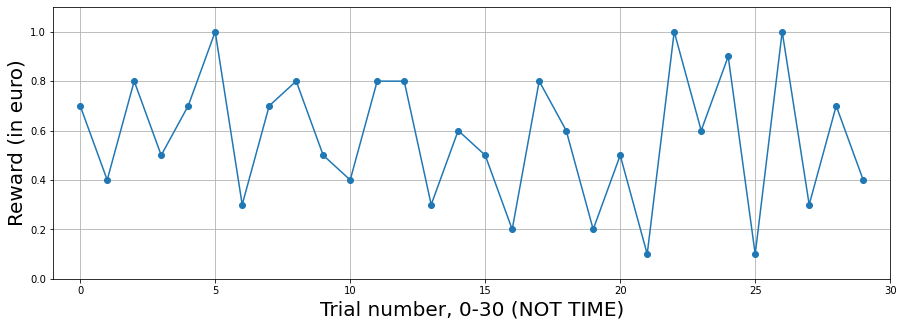

In [10]:
np.random.seed(42)
exp_time = 60 * 10  # i.e., 14 minutes in seconds
n_trials = 30
reward_onsets = np.arange(4, exp_time, exp_time / n_trials).astype(int)
print("Number of trials: %i" % reward_onsets.size)

reward_magnitudes = np.random.randint(1, 11, size=reward_onsets.size) / 10

plt.figure(figsize=(15, 5))
plt.plot(reward_magnitudes, marker='o')
plt.xlim(-1, reward_magnitudes.size)
plt.ylim(0, 1.1)
plt.xlabel('Trial number, 0-%i (NOT TIME)' % n_trials, fontsize=20)
plt.ylabel('Reward (in euro)', fontsize=20)
plt.grid()
plt.show()

Now, in non-parametric designs, we would create regressors with zeros everywhere and ones at the onset of stimuli (or whatever we think will impact the fMRI data). However, in parametric designs, we create two regressors for every parametric modulation: one for the unmodulated response and one for the modulated response.

Let's start with the unmodulated response. This predictor is created like we did before: convolving a stick predictor with an HRF:

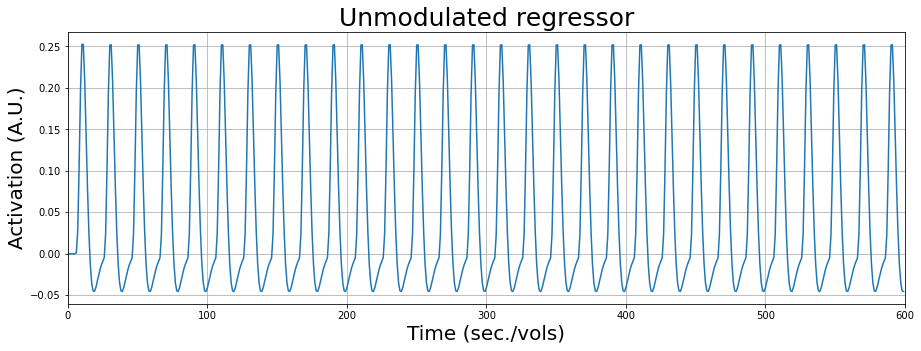

In [11]:
hrf = glover_hrf(tr=1, oversampling=1)

x_unmod = np.zeros(exp_time)
x_unmod[reward_onsets] = 1
x_unmod = np.convolve(x_unmod, hrf)[:exp_time]

plt.figure(figsize=(15, 5))
plt.plot(x_unmod)
plt.xlim(0, exp_time)
plt.xlabel('Time (sec./vols)', fontsize=20)
plt.ylabel('Activation (A.U.)', fontsize=20)
plt.title('Unmodulated regressor', fontsize=25)
plt.grid()
plt.show()

Now, the parametrically modulated regressor is created as follows: instead of creating an initial array with zeros and *ones* at indices corresponding to the reward onset, we use the (mean-subtracted) *reward magnitude*. It is important to subtract the mean from the parametric modulation values, because this will "decorrelate" the modulated regressor from the unmodulated regressor (such that the modulated regressor explains only variance that is due to modulation of the response, not the common response towards the stimulus/task). In other words, subtracting the mean from the parametric regressor *orthogonalises* the parametric regressor with respect to the unmodulated regressor.

Then, the predictor is again convolved with the HRF to create the final modulated predictor.

<div class='alert alert-success'>
    <b>Tip</b>: Check out <a href="https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0126255">this excellent paper</a> by Mumford and colleagues (2015), which discusses orthogonalization in fMRI designs and when it is (in)appropriate. <a href="https://www.youtube.com/watch?v=2W7Rso-4Hqg">This video</a> also nicely explains orthogonalization in the context of parametric modulation analyses.
</div>

We will subtract the mean from the parametric modulation values (<tt>reward_magnitudes</tt>) and save this in a new variable named <tt>reward_magnitudes_ms</tt>. 
Next, we will create a new zeros-filled predictor, and set the values corresponding to the reward onsets to the mean-subtract reward magnitudes. Then, convolve the predictor with the HRF (use the variable <tt>hrf</tt> defined earlier) and trim off the excess values. The result, we will store in a variable named <tt>x_mod</tt>. Lastly, we will plot the modulated regressor.


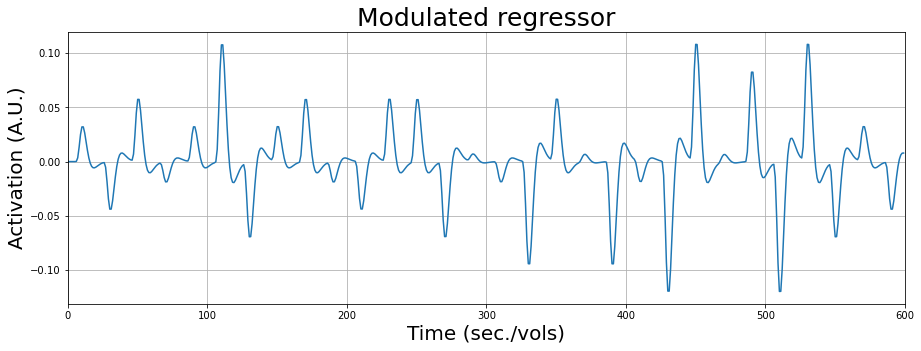

In [12]:
#De-mean parametric modulator
reward_magnitudes_ms = reward_magnitudes- reward_magnitudes.mean()
#Create a vector with zeros for each datapoint
x_mod = np.zeros(exp_time)
#Add the parametric values at the right timepoints
x_mod[reward_onsets] = reward_magnitudes_ms
#Convolve the vector with the HRF and trim to length of exp.
x_mod = np.convolve(x_mod, hrf)[:exp_time]
#Plot
plt.figure(figsize=(15, 5))
plt.plot(x_mod)
plt.xlim(0, exp_time)
plt.xlabel('Time (sec./vols)', fontsize=20)
plt.ylabel('Activation (A.U.)', fontsize=20)
plt.title('Modulated regressor', fontsize=25)
plt.grid()
plt.show()


Now, we will stack an intercept, the unmodulated regressor, and the modulated regressor in a single design matrix (with three columns; you might have to create a singleton axis with <tt>np.newaxis</tt>!). Make sure the order of the columns is as follows: intercept, unmodulated regressor, modulated regressor. Then, run linear regression with this design matrix on the variable <tt>y_reward_signal</tt> below. Save the parameters in a variable named <tt>betas_reward</tt>.


In [13]:
# Let's fetch some premade data to test our model on
y_reward_signal = np.load('data/y_reward_signal.npy')

#Create an intercept
icept = np.ones((x_mod.size, 1))
#Stack the variables in a design matrix
dm = np.hstack((icept, x_unmod[:, np.newaxis], x_mod[:, np.newaxis]))
#Estimate the model
betas_reward = inv(dm.T @ dm) @ dm.T @ y_reward_signal
#Inspect
print(betas_reward)

[-1.99808016e-03  1.05404835e+00  2.19517292e+00]


<div class='alert alert-info'>
    <b>ToThink1</b>: Interpret the direction of the effect of the unmodulated and modulated predictors. How does this voxel respond to the reward events?
</div>

Write your answer to the ToThink1 question here:

## Design variance/efficiency
Alright, hopefully you now know how to design contrasts for factorial and parameteric designs! This section has a slightly different focus, namely the mathematics behind design variance and efficiency! Remember that we wouldn't tell you what "design variance" was in the previous two GLM tutorials? Well, now we're going to discuss and explain it *extensively*! Before we delve into this topic, let's first recap the (conceptual) formula for the *t*-value from the previous tutorial (`06_GLM_part3_inference.ipynb`) (the relevance of this will become clear shortly).

In the previous tutorial, you learned about the GLM and how to apply it to fMRI data to find out how much influence each predictor in your design has on the signal of a voxel. Crucially, you learned that you shouldn't look at raw beta-parameters to infer the effect of predictors, but that you should look at *normalized beta-parameters* &mdash; the **_t_-value**. Remember the formula for the *t*-value for a given contrast ($c$)?

\begin{align}
t_{\mathbf{c}\hat{\beta}} = \frac{\mathrm{effect}}{\sqrt{\mathrm{noise \cdot design\ variance}}} = \frac{\mathbf{c}\hat{\beta}}{\sqrt{\frac{SSE}{\mathrm{DF}} \cdot \mathrm{design\ variance}}}
\end{align}

The formula for the *t*-value embodies the concept that the statistics you (should) care about, *t*-values, depend both on the **effect** (sometimes confusingly called the "signal"; $\hat{\beta}$), the **noise** ($\hat{\sigma}^{2} = \frac{SSE}{\mathrm{DF}}$), and the **"design variance"**.

So, to find optimal (i.e. largest) *t*-values, we should try to optimize both the effect of our predictors (i.e. the betas), try to minimize the errors ($\hat{\sigma}^2$), and try to minimize the design variance of our model. In this lab, we'll shortly discuss the "effect" component ($\hat{\beta}$) and thereafter we'll discuss in detail the "design variance" part. We won't discuss the "noise" part, as this will be the topic of next week (preprocessing).

### Optimizing "effects"

#### Psychological factors
As discussed above, the "effect" part of the conceptual formula for the t-statistic refers to the $\beta$-parameter in the statistical formula. It may sound weird to try to "optimize" your effect, because there is no way to magically acquire a better/stronger effect from your data, right? (Well, apart from using a better/stronger MRI-scanner.) Actually, don't forget that the effect you're measuring is coming from the brain of a *human* beings (your subjects)! There are real and important psychological influences that affect the strength of your signal, and thus influence eventually the size of your $\beta$-parameter. 

So, what are these psychological influences? Well, think about inattention/boredom, anxiety, sleepiness (don't underestimate how many subjects fall asleep in the scanner!), and subjects not understanding your task. As an extreme example: suppose you're showing your subject some visual stimuli in order to measure the effect of some visual property (e.g., object color) in the visual cortex. Imagine that your subject finds the task so boring that he/she falls asleep; the $\beta$-parameters in this scenario are going to be *much* lower than when the subject wouldn't have fallen asleep, of course! Sure, this is an extreme (but not uncommon!) example, but it shows the potential influence of psychological factors on the "effect" you're measuring in your data!

In short, when designing an experiment, you want to continually ask yourself: *Are subjects really doing/thinking the way I want them to?*, and consequently: *Am I really measuring what I think I'm measuring?* 

(The effect of psychological aspects on the measured effect is thoroughly explained in the video [Psychological principles in experimental design](https://www.youtube.com/watch?v=lwy2k8YQ-cM) from Tor Wager.)

#### Design factors
Apart from taking psychological factors into account when designing your experiment, there are also design-technical factors that influence the (potential) strength of your signal: using blocked designs. We will, however, discuss this topic in a later section, because you need a better understanding of another part of the conceptual *t*-value formula first: design variance.

### Optimizing design variance
In the previous tutorial, we talked quite a bit about this mysterious term "design variance" and we promised to discuss it later. That's exactly what we're going to do now. As we shortly explained, *design variance is the part of the standard error caused by the design-matrix ($X$)*. Importantly, design variance is closely related to the *efficiency* of the design matrix ($X$), i.e., efficiency is the inverse of design variance:

\begin{align}
\mathrm{efficiency} = \frac{1}{\mathrm{design\ variance}}
\end{align}

This term, efficiency, will be important in the rest of this notebook. 

As these terms are inversely related, high design variance means low efficiency (which we don't want) and low design variance means high efficiency (which we want). Phrased differently, high design variance means that your design-matrix is (relatively) *inefficient* for our goal to measure significant effects (i.e., high *t*-values). But, as you might have noticed, this definition is kind of circular. What causes low design variance (high efficiency), or: what constitutes an efficient design?

Basicially, two factors contribute to an efficient design:
1. The predictors in your design should have **high variance** (i.e. they should vary a lot relative to their mean)
2. The predictors should **not** have **high covariance** (i.e. they should not correlate between each other a lot)

In general, for any **contrast between two $\beta$-parameters corresponding to predictor $j$ and $k$**, we can define their design variance as follows\*:

\begin{align}
\mathrm{design\ variance}_{j,k} = \frac{1}{\mathrm{var}[X_{j}] + \mathrm{var}[X_{k}] - 2\cdot \mathrm{cov}[X_{j}, X_{k}]}
\end{align}

As such, efficiency for this contrast would the inverse:

\begin{align}
\mathrm{efficiency}_{j,k} = \mathrm{var}[X_{j}] + \mathrm{var}[X_{k}] - 2\cdot \mathrm{cov}[X_{j}, X_{k}]
\end{align}

As you can see, design variance thus depends on the variance of the predictors *and* the covariance between predictors. Note that this formulation only applies to contrasts involving more than one parameter. For **contrasts against baseline, in which only one parameter is tested (e.g. predictor $j$)**, there is only one variance term (the other variance term and the covariance term are dropped out):

\begin{align}
\mathrm{design\ variance}_{j} = \frac{1}{\mathrm{var}[X_{j}]}
\end{align}

It is of course kind of annoying to have two different definitions (and computations) of design variance, which depend on whether you want to test a parameter against baseline or against another parameter. Therefore, people usually use the vectorized computation (i.e. using matrix multiplication), which allows you to define the formula for design variance *for any contrast-vector $\mathbf{c}$*:

\begin{align}
\mathrm{design\ variance} = \frac{1}{\mathrm{var}[X_{j}] + \mathrm{var}[X_{k}] - 2\cdot \mathrm{cov}[X_{j}, X_{k}]} = \mathbf{c}(\mathbf{X}^T\mathbf{X})^{-1}\mathbf{c}^{T}
\end{align}

While this notation, $\mathbf{c}(\mathbf{X}^{T}\mathbf{X})^{-1}\mathbf{c}$, may seem quite different than the above definitions using the $\mathrm{var}$ and $\mathrm{cov}$ terms, it is mathematically doing the same thing. The term $(X^{T}X)^{-1}$ represents (the inverse of) the variance-covariance matrix of the design ($X$) and **c** (contrast vector) is used only to "extract" the relevant variances and covariance for the particular contrast out of the entire covariance matrix of $X$.

While appearing more complex, the advantage of the vectorized definition, however, is that it works for both contrasts against baseline (e.g. `[0, 0, 1]`) and contrasts between parameters (e.g. `[0, 1, -1]`). Now, if we plug in this mathematical definition of design variance in the formula of the standard error of a given contrast, we get:

\begin{align}
\mathrm{SE}_{\mathbf{c}\hat{\beta}} = \sqrt{\mathrm{noise} \cdot \mathrm{design\ variance}} = \sqrt{\hat{\sigma}^{2}\mathbf{c}(\mathbf{X}^{T}\mathbf{X})^{-1}\mathbf{c}^{T}}
\end{align}

Now, we can write out the entire formula for the *t*-statistic:

\begin{align}
t_{\mathbf{c}\hat{\beta}} = \frac{\mathbf{c}\hat{\beta}}{\sqrt{\hat{\sigma}^{2}\mathbf{c}(X'X)^{-1}\mathbf{c}'}} = \frac{\mathrm{effect}}{\sqrt{\mathrm{noise} \cdot \mathrm{design\ variance}}}
\end{align}

---
\* Actually, design variance does not depend on the "variance" and "covariance", but on the sums-of-squares of each predictor $j$ ($\mathrm{SS}_{X_{j}}$) and sums-of-squares cross-products ($\mathrm{SS}_{X_{j}, X_{k}}$), respectively. These are just the variance and covariance terms, but without dividing by $N - 1$! We used the terms variance and covariance here because they are more intuitive.

### Summary: effects, noise, and design variance

Alright, that's a lot of math. Sorry about that. But the above formula nicely illustrates that, to obtain large effects (i.e. *t*-values), you need three things:

1. A large response/effect (i.e. $\beta$)
2. An efficient design or, in other words, low design variance (i.e. high variance, low covariance: $\frac{1}{c(X^{T}X)^{-1}c'}$)
3. Low noise/unexplained variance (i.e. low $\mathrm{SSE}\ /\ \mathrm{DF}$)

In this tutorial, we'll discuss how to optimize (2): the efficiency from the design. In the next, we'll discuss how to minimize (3): noise (unexplained variance).

If you remember these three components and how they conceptually relate to the effect we want to measure (*t*-values), you understand the most important aspect of experimental design in fMRI! In the rest of the tutorial, we're going to show you **why** you want high variance and low covariance in your design ($X$) and **how** to achieve this by designing your experiment in a specific way.

<div class='alert alert-warning'>
<b>Playing with the design variables</b>
    
In the previous section, you've seen a lot of math and definitions of (statistical) concepts. Especially the part on the inverses (e.g. efficiency is the inverse of design-variance, and vice versa). 

It is important to understand how all the concepts (signal/beta, noise/SSE, design variance, efficiency) relate to each other and to the thing we're after: strong effects (high *t*-values)!

Therefore, we captured the *conceptual* formula in a function below named <tt>conceptual_tvalue_calculator</tt>, which takes three inputs &mdash; signal, noise, and design variance &mdash; and outputs the effect (*t*-value) and design efficiency. 

In the cell below, we call the function with some particular values for the three input-arguments (<tt>SIGNAL</tt>, <tt>NOISE</tt>, <tt>DESIGN_VARIANCE</tt>). For this (ungraded) ToDo, try to change these input parameters and try to understand how changing the inputs changes the outputs!
</div>

In [14]:
def conceptual_tvalue_calculator(signal, noise, design_variance):
    """ Calculate the effect (t-value) from the signal, noise, and design variance components.
    
    Parameters
    ----------
    signal : int/float
    noise : int/float
    design_variance : int/float
    
    Returns
    -------
    effect : float
    efficiency : float
    """
    efficiency = 1 / design_variance
    effect = signal / (noise * design_variance)
    return effect, efficiency

In [15]:
# Change the capitalized variables to see what effect it has on the t-value and efficiency
SIGNAL = 0.5
NOISE = 2.8
DESIGN_VARIANCE = 0.02

effect, efficiency = conceptual_tvalue_calculator(signal=SIGNAL, noise=NOISE, design_variance=DESIGN_VARIANCE)

print("Effect ('t-value'): %.3f" % effect)
print("Efficiency: %.3f" % efficiency)

Effect ('t-value'): 8.929
Efficiency: 50.000



<b>NB.</b> *Experimental design efficiency is independent of the actual data*: 

Researchers do not need to acquire (fMRI) data ($\mathbf{y}$) to calculate the efficiency of their design ($\mathbf{X}$). The design variance and thus efficiency terms do not depend on $y$.


### How to calculate design variance and efficiency in Python
As discussed in the previous section, the formula for design variance (and efficiency) is often expressed using linear algebra notation:

\begin{align}
\mathrm{design\ variance} = \mathbf{c}(\mathbf{X}^{T}\mathbf{X})^{-1}\mathbf{c}^{T}
\end{align}

You have seen the $(\mathbf{X}^{T}\mathbf{X})$ earlier when we discussed the solution for finding the least squares solution. Now, design variance is calculated by pre and postmultiplying this term with the (transpose of the) contrast vector (denoted with `c` and `c.T`). As such, so the full design variance calculation can be implemented in python as follows:

```python
design_var = c @ inv(X.T @ X) @ c.T
```

Given that efficiency is the inverse of design variance:

\begin{align}
\mathrm{efficiency} = \frac{1}{\mathbf{c}(\mathbf{X}^{T}\mathbf{X})^{-1}\mathbf{c}^{T}}
\end{align}

... we can calculate efficiency as:

```python
efficiency = 1.0 / (c @ inv(X.T @ X) @ c.T)
```

You'll have to implement this yourself in a later ToDo! But first, let's go into more detail *why* high variance and low covariance are important to get large effects!

## The effect of predictor variance on design variance/efficiency
As explained in the previous section, design variance depends on (1) predictor variance and (2) predictor covariance. In this section, we'll focus on predictor variance. In the next section, we'll focus on predictor covariance.

As you probably know, *variance* is a statistical property of a random variable that describes the average squared deviation from the variable's mean. Formally, for any variable $x$ with mean $\bar{x}$ and length $N$, its sample variance is defined as:

\begin{align}
\mathbf{var}[x] = \frac{1}{N - 1}\sum_{i=1}^{N}(x - \bar{x})^{2}
\end{align}

So, the more values of a variable deviate from its mean on average, the more variance it has.

To demonstrate the effect of predictor variance on design variance/efficiency, we will focus (for simplicity) on non-time series designs that have just a single condition and thus a single predictor (apart from the intercept). In these examples, we'll focus on why high variance is important. 

### An example of the effect of (high) design variance
To start, we want to show you &mdash; conceptually &mdash; why it is important to have a lot of variance in your predictors for a low standard error of your beta, and thus high t-values. We're going to show you an example of 'regular' linear regression (so no time-series signal, but the example holds for MRI data).

Suppose we want to investigate the effect of someone's IQ on their income ($\mathbf{X} = IQ$, $\mathbf{y} = income$). We've gathered some data, which we'll as usual represent as an independent variable ($\mathbf{X}$) and a dependent variable ($\mathbf{y}$). We'll also run the regression analysis and calculate the beta-parameters, MSE and *t*-value (corresponding to the IQ-parameter "against baseline").

Shape X: (100, 2)
Shape y: (100,)


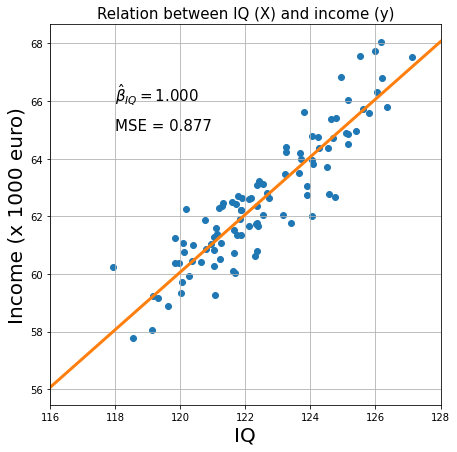

In [16]:
# First a function that can calculate stats. It is a repetition of previous stuff and can be skipped
def calculate_stats_for_iq_income_dataset(iq_income_data, which='lowvar'):
    
    if which == 'lowvar':
        X, y = iq_income_data['X_lv'], iq_income_data['y_lv']
    else:
        X, y = iq_income_data['X_hv'], iq_income_data['y_hv']
        
    contrast = np.array([0, 1])
    beta = np.linalg.lstsq(X, y, rcond=None)[0]
    y_hat = X.dot(beta)
    mse = ((y - y_hat) ** 2).mean()
    des_var = contrast.dot(np.linalg.pinv(X.T.dot(X))).dot(contrast.T)
    sse_df = ((y - y_hat) ** 2).sum() / (X.shape[0] - X.shape[1])
    se = np.sqrt(sse_df * des_var)
    tval = contrast.dot(beta) / se
    return beta, mse, tval


# Load the data
iq_income_data = np.load('data/iq_variance_example.npz')
X_lowvar = iq_income_data['X_lv']
y_lowvar = iq_income_data['y_lv']
print("Shape X: %s" % (X_lowvar.shape,))
print("Shape y: %s" % (y_lowvar.shape,))

beta_lv, mse_lv, tval_lv = calculate_stats_for_iq_income_dataset(iq_income_data, which='lowvar')

plt.figure(figsize=(7, 7))
plt.title("Relation between IQ (X) and income (y)", fontsize=15)
plt.scatter(X_lowvar[:, 1], y_lowvar, c='tab:blue')
plt.ylabel('Income (x 1000 euro)', fontsize=20)
plt.xlabel('IQ', fontsize=20)
plt.plot(
    (116, 128), 
    (116 * beta_lv[1] + beta_lv[0], 128 * beta_lv[1] + beta_lv[0]), c='tab:orange', lw=3
)
plt.text(118, 66, r'$\hat{\beta}_{IQ} = %.3f$' % beta_lv[1], fontsize=15)
plt.text(118, 65, 'MSE = %.3f' % mse_lv, fontsize=15)
plt.grid()
plt.xlim(116, 128)
plt.show()

This is pretty awesome data! On average, our prediction is on average less than 1 point off (i.e., $\mathrm{MSE} < 1$)! But you might also have noticed that the *range* of values for $X$ (i.e., IQ) is quite limited: we only measured people with IQs between about 118 and 127. This is quite a narrow range &mdash; in other words: little variance &mdash; knowing that IQ varies according to a normal distribution with mean 100 and standard deviation 15. In other words, we have a pretty good model, but it is only based on a specific range of the IQ-variable. 

Think about it this way: this model captures the relationship between IQ and income, but only for relatively high-intelligence people. Sure, you can extrapolate to IQ-values like 80 and 90, but this extrapolation is quite uncertain because you've never even measured someone with that IQ-value! 

So, for comparison, let's a similar dataset with IQ and income, but this time with a much larger range of the IQ-variable. We'll plot the two datasets (the low-variance and high-variance data) next to each other. 

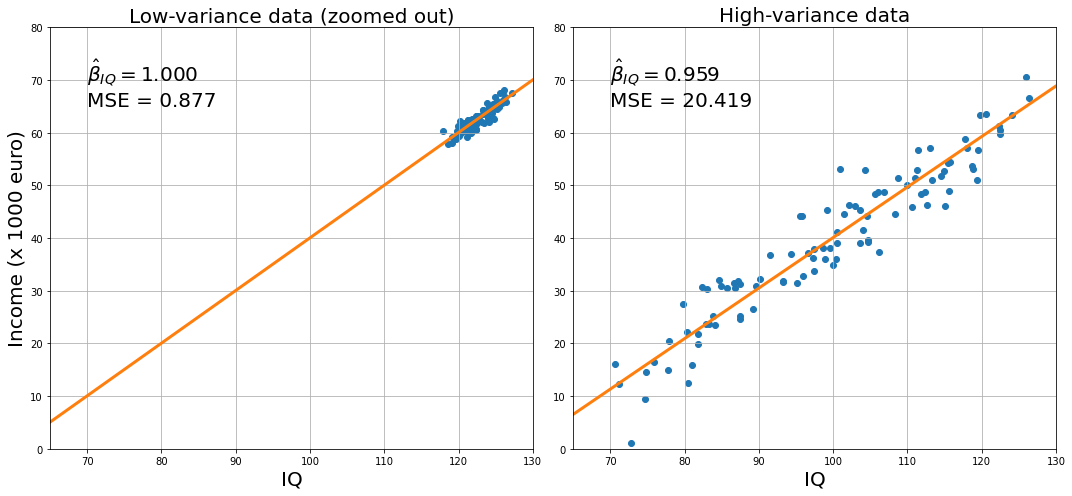

In [17]:
X_highvar = iq_income_data['X_hv']
y_highvar = iq_income_data['y_hv']

x_lim = (65, 130)
y_lim = (0, 80)

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.title("Low-variance data (zoomed out)", fontsize=20)
plt.scatter(X_lowvar[:, 1], y_lowvar, c='tab:blue')
plt.ylabel('Income (x 1000 euro)', fontsize=20)
plt.xlabel('IQ', fontsize=20)
plt.xlim(x_lim)
plt.ylim(y_lim)
plt.plot(x_lim, (x_lim[0] * beta_lv[1] + beta_lv[0], x_lim[1] * beta_lv[1] + beta_lv[0]), c='tab:orange', lw=3)
plt.text(70, 70, r'$\hat{\beta}_{IQ} = %.3f$' % beta_lv[1], fontsize=20)
plt.text(70, 65, 'MSE = %.3f' % mse_lv, fontsize=20)
plt.grid()

# Now, do the same calculations for the highvar data
beta_hv, mse_hv, tval_hv = calculate_stats_for_iq_income_dataset(iq_income_data, which='highvar')

plt.subplot(1, 2, 2)
plt.title("High-variance data", fontsize=20)
plt.scatter(X_highvar[:, 1], y_highvar, c='tab:blue')
plt.xlim(x_lim)
plt.ylim(y_lim)
plt.xlabel('IQ', fontsize=20)
plt.plot(x_lim, (x_lim[0] * beta_hv[1] + beta_hv[0], x_lim[1] * beta_hv[1] + beta_hv[0]), c='tab:orange', lw=3)
plt.text(70, 70, r'$\hat{\beta}_{IQ} = %.3f$' % beta_hv[1], fontsize=20)
plt.text(70, 65, 'MSE = %.3f' % mse_hv, fontsize=20)
plt.tight_layout()
plt.grid()
plt.show()

As you can see from the plots of the two datasets side-by-side, both the low-variance (left) and the high-variance plot (right) capture approximately the model: for each increase in an IQ-point, people earn about 1000 (low-variance model) / 959 (high-variance model) euro extra (these are reflected by the beta-parameters!).

But, you also see that the MSE for the high-variance model is *much* higher, which is also evident from the residuals (distance of the red points from the blue line).

In [18]:
mse_ratio = mse_hv / mse_lv
print("The MSE of the high-variance data is %.3f times larger than the low-variance data!" % mse_ratio)

The MSE of the high-variance data is 23.279 times larger than the low-variance data!


Given these statistics, you might guess that the t-value of the IQ-parameter in the high-variance model would be way lower than the same parameter in the low-variance model, right? Well, let's check it out:

In [19]:
# We calcalated the t-values earlier with the calculate_stats_for_iq_income_dataset function
print("T-value low-variance model: %.3f" % tval_lv)
print("T-value high-variance model: %.3f" % tval_hv)

T-value low-variance model: 21.189
T-value high-variance model: 31.156


You probably by now understand what's the culprit: the design-variance! Given that the effect ($\hat{\beta}_{IQ}$) is about the same for the two models and the MSE is higher for the high-variance model, the logical conclusion is that *the design-variance of the high-variance model must be waaaaay lower*.


We can show this by using the two design-matrices (<tt>X_highvar</tt> and <tt>X_lowvar</tt>) to calculate the design-variances of both the low-variance and the high-variance dataset for the "contrast against baseline", i.e., $H_{0}: \beta_{IQ} = 0$ and $H_{a}: \beta_{IQ} \neq 0$. Then, divide the design-variance of the low-variance dataset by the high-variance dataset and store this in the variable <tt>desvar_ratio</tt> (this indicates how much higher the design-variance of the low-variance dataset is compared to the high-variance dataset). 


In [20]:
#Contrast vector excluding the intercept
c = np.array([0, 1])
# Implementing the formula from above for the two designs
desvar_lv = c @ inv(X_lowvar.T @ X_lowvar) @ c.T
desvar_hv = c @ inv(X_highvar.T @ X_highvar) @ c.T
desvar_ratio = desvar_lv / desvar_hv

print("Design variance low-variance model: %.3f" % desvar_lv)
print("Design variance high-variance model: %.3f" % desvar_hv)
print("Ratio between design variances: %.3f" % desvar_ratio)

Design variance low-variance model: 0.002
Design variance high-variance model: 0.000
Ratio between design variances: 54.708


<b>NB.</b> Design efficiency (and design-variance) is a metric without a clear unit of measurement; herefore, efficiency (and design variance) should always be interpreted in relative terms. To show this, we are going to look at the example from the previous tutorial (`06_GLM_part3_inference.ipynb`), in which we used weight as a predictor for height. Now, we're going to rescale the predictor ('weight') such that it represents weight in <em>grams</em> instead of *kilos* (as was originally the case).

Next, we will calculate efficiency for both the weight-in-kilos data (<tt>X_kilos</tt>) and the weight-in-grams data (<tt>X_grams</tt>). Store the efficiency for the weight-in-kilos data in a variable named <tt>efficiency_kilos</tt> and the efficiency for the weight-in-grams data in a variable named <tt>efficiency_grams</tt>. 


In [21]:
with np.load('data/weight_height_data.npz') as data:
    X_kilos = data['X']
    X_grams = X_kilos * 1000
    
    # We'll stack an intercept for you!
    intercept = np.ones((X_kilos.size, 1))
    X_kilos = np.hstack((intercept, X_kilos))
    X_grams = np.hstack((intercept, X_grams))


c = np.array([0, 1])
efficiency_kilos = 1.0 / (c @ inv(X_kilos.T @ X_kilos) @ c.T)
efficiency_grams = 1.0 / (c @ inv(X_grams.T @ X_grams) @ c.T)

print("Design efficiency kilo model: %.10f" % efficiency_kilos)
print("Design efficiency gram model: %.10f" % efficiency_grams)


Design efficiency kilo model: 2997.2126522714
Design efficiency gram model: 2997212652.2714414597


You should see that (everything else being equal) the design with weight in grams is a 1,000,000 times more efficient than the design with weight in kilos.

This is because the scale-difference gets squared in the $X^{T}X$ calculation.

## The effect of predictor covariance on design variance/efficiency

### Multicollinearity
In the previous section, we discussed the influence of predictor variance - $\mathrm{var}[\mathbf{X}_{j}]$ - on the design-variance term, showing that high variance leads to (relatively) low design variance (and thus high efficiency). 

We know, however, that design variance *also* depends on the *covariance* between predictors - $\mathrm{cov}[\mathbf{X}_{j}, \mathbf{X}_{k}]$. This "covariance between predictors" is also known as **multicollinearity**. 

Specifically, the **higher** the covariance (multicollinearity), the **lower** the design efficiency (the worse our design is). Conceptually, you can think of high covariance between predictors as causing *uncertainty* of the estimation of your beta-estimates: if your predictors are correlated, the GLM "doesn't know" what (de)activation it should assign to which predictor. This uncertainty due to correlated predictors is reflected in a (relatively) higher design variance term.

Anyway, let's look at some (simulated) data. This time (unlike the variance-example), we're going to look at fMRI timeseries data. We'll simulate a design with two predictors, we'll calculate the correlation between the two predictors, and the efficiency of the design for the difference contrast between the predictors (`c = [0, 1, -1]`).

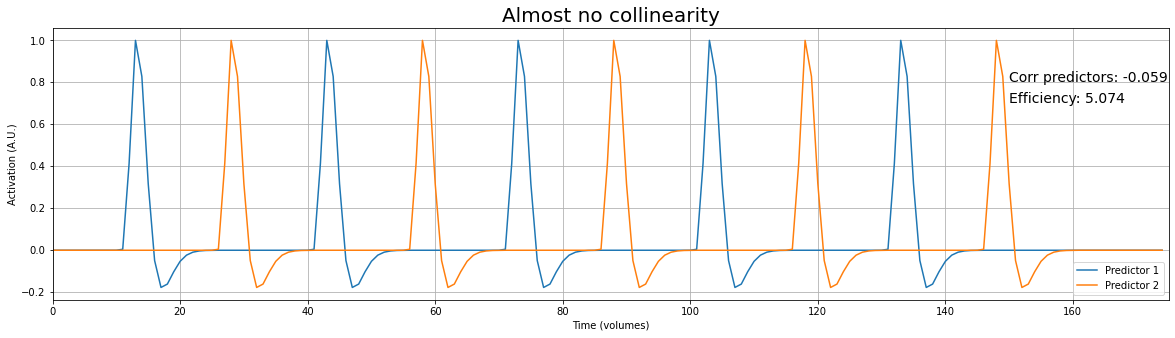

Variance predictor 1: 0.055
Variance predictor 2: 0.055


In [22]:
def simulate_two_predictors(N=360, shift=30, TR=2):
    ''' Simulates two predictors with evenly spaced trials,
    shifted a given number of time-points. '''
    
    offset = 20
    stop = 300
    space = 60
    pred1 = np.zeros(N)
    pred1[offset:stop:space] = 1
    pred2 = np.zeros(N)
    pred2[(offset + shift):stop:space] = 1

    hrf = glover_hrf(tr=1, oversampling=1)
    hrf /= hrf.max()
    pred1 = np.convolve(pred1, hrf)[:N:int(TR)]
    pred2 = np.convolve(pred2, hrf)[:N:int(TR)]
    X = np.hstack((np.ones((int(N / 2), 1)), pred1[:, np.newaxis], pred2[:, np.newaxis]))
    return X

# We set the "shift" (distance between predictor 1 and 2 to 30 seconds)
X = simulate_two_predictors(N=350, shift=30, TR=2)
cvec = np.array([0, 1, -1])
corr = pearsonr(X[:, 1], X[:, 2])[0]
eff = 1.0 / cvec.dot(np.linalg.inv(X.T.dot(X))).dot(cvec.T)
plt.figure(figsize=(20, 5))
plt.plot(X[:, 1])
plt.plot(X[:, 2])
plt.text(150, 0.8, 'Corr predictors: %.3f' % corr, fontsize=14)
plt.text(150, 0.7, 'Efficiency: %.3f' % eff, fontsize=14)
plt.xlim(0, 175)
plt.legend(['Predictor 1', 'Predictor 2'], loc='lower right')
plt.xlabel("Time (volumes)")
plt.ylabel("Activation (A.U.)")
plt.title("Almost no collinearity", fontsize=20)
plt.grid()
plt.show()

print("Variance predictor 1: %.3f" % np.var(X[:, 1], ddof=1))
print("Variance predictor 2: %.3f" % np.var(X[:, 2], ddof=1))

As you can see, the predictors are almost perfectly uncorrelated - $\mathrm{corr}(\mathbf{X}_{1}, \mathbf{X}_{2}) \approx 0$ - which corresponds to a design efficiency of 5.074. Remember, the absolute value of efficiency is not interpretable, but we can interpret it *relative to other designs*. As such, we can investigate how a design with more correlated predictors will change in terms of efficiency.

To do so, we can simply "shift" the second predictor (blue line) to the left (i.e., the stimuli of predictor 2 follow the stimuli of predictor 1 more quickly). Let's check out what happens to the efficiency if we induce corelation this way:

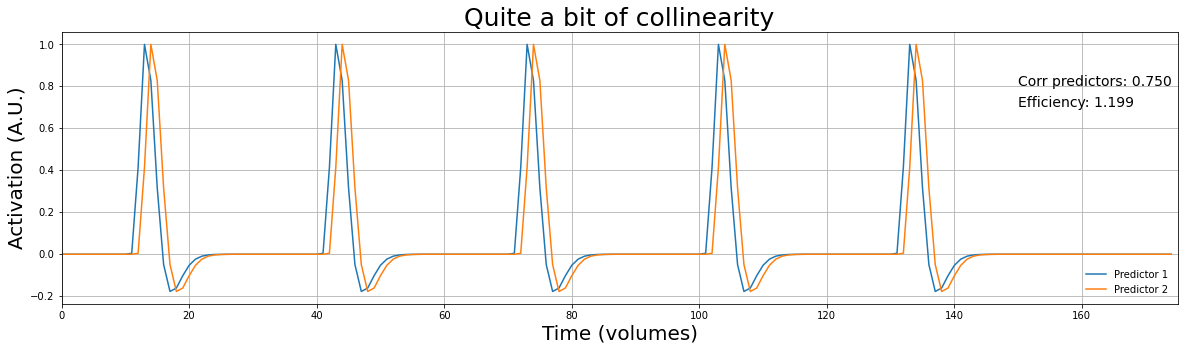

Variance predictor 1: 0.055
Variance predictor 2: 0.055


In [23]:
# We set shift to 4 seconds (instead of 30 like before)
X2 = simulate_two_predictors(N=350, shift=2, TR=2)
corr2 = pearsonr(X2[:, 1], X2[:, 2])[0]
eff2 = 1.0 / cvec.dot(np.linalg.inv(X2.T.dot(X2))).dot(cvec.T)
plt.figure(figsize=(20, 5))
plt.plot(X2[:, 1])
plt.plot(X2[:, 2])
plt.text(150, 0.8, 'Corr predictors: %.3f' % corr2, fontsize=14)
plt.text(150, 0.7, 'Efficiency: %.3f' % eff2, fontsize=14)
plt.xlim(0, 175)
plt.legend(['Predictor 1', 'Predictor 2'], loc='lower right', frameon=False)
plt.xlabel("Time (volumes)", fontsize=20)
plt.ylabel("Activation (A.U.)", fontsize=20)
plt.title("Quite a bit of collinearity", fontsize=25)
plt.grid()
plt.show()

print("Variance predictor 1: %.3f" % np.var(X2[:, 1], ddof=1))
print("Variance predictor 2: %.3f" % np.var(X2[:, 2], ddof=1))

In [24]:
# Let's calculate the reduction in efficiency
reduction_eff = ((eff - eff2) / eff) * 100
print("Efficiency is reduced with %.1f%% when increasing the correlation to %.3f" % (reduction_eff, corr2))

Efficiency is reduced with 76.4% when increasing the correlation to 0.750


As you can see, increasing correlation between predictors has the effect of reducing efficiency, even if the predictor variance stays the same! Like we discussed earlier, this is because correlation between predictors reflects *ambiguity* about the "source" of an effect. 

To get a better intuition of this ambiguity, suppose that for the above design (with the correlated predictors), we observe the following signal (we just simulate the signal as the linear sum of the predictors + noise; sort of a "reverse linear regression"):

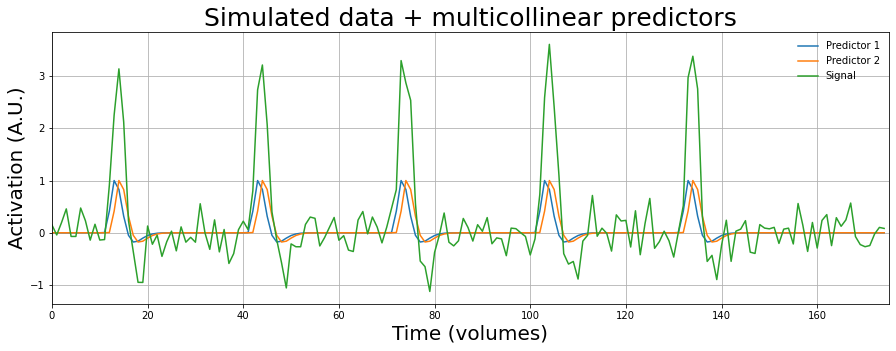

In [25]:
np.random.seed(42)

# Here we simulate a signal based on the predictors + noise
some_noise = + np.random.normal(0, 0.3, X2.shape[0])
sim_signal = X2[:, 1] * 2 + X2[:, 2] * 2  + some_noise
plt.figure(figsize=(15, 5))
plt.plot(X2[:, 1])
plt.plot(X2[:, 2])
plt.plot(sim_signal)
plt.xlim(0, 175)
plt.legend(['Predictor 1', 'Predictor 2', 'Signal'], loc='upper right', frameon=False)
plt.xlabel("Time (volumes)", fontsize=20)
plt.ylabel("Activation (A.U.)", fontsize=20)
plt.title("Simulated data + multicollinear predictors", fontsize=25)
plt.grid()
plt.show()

Now, if we calculate the beta-parameters of both predictors, we see that they both are given approximately equal "importance" (i.e., their beta-parameters are about equally high):

In [26]:
betas = inv(X2.T @ X2) @ X2.T @ sim_signal
print("Betas (w/o intercept): %r" % betas[1:])

Betas (w/o intercept): array([1.83906143, 1.96990025])


However, it is unclear to the GLM whether the peaks in the signal (green line) are caused by predictor 1 or predictor 2! While the betas themselves are not affected on average (i.e., there is no *bias*), this "uncertainty" (or "ambiguity") is reflected in the GLM through a relatively higher design variance term, that will subsequently lead to (relatively) lower *t*-values! 

### Evaluating multiple contrasts
Thus far, we only evaluated the efficiency for a *single* contrast, like one particular predictor against baseline, e.g. `contrast_vec = np.array([0, 1, 0])`. Often, though, you might be interested in *more than one contrast*. For example, you might be interested in the contrast of predictor "A" against baseline, predictor "B" against baseline, and the difference between predictor "A" and "B"\*. We can simply extend our formula for efficiency to allow more than one contrast. For $K$ contrasts, efficiency is defined as:

\begin{align}
\mathrm{efficiency} = \frac{K}{\sum_{k=1}^{K} \mathbf{c}_{k}(\mathbf{X}^{T}\mathbf{X})^{-1}\mathbf{c}_{k}^{T}}
\end{align}

This specific calculation of efficiency is also referred to as "A optimality". From the formula, you can see that the overall efficiency for multiple contrasts is basically (but not precisely) the "average" of the efficiencies for the individual contrasts. 

Let's practice the Python-implementation of overall efficiency for multiple contrasts in a short assignment (graded with hidden tests).

---
\* Note that evaluating different contrasts separately is not the same as doing an F-test (like we discussed in the previous tutorial)!


<b>Example</b> With the data from the correlation-simulation (i.e., the variable <tt>X</tt>), we will now calculate the efficiency for the set of the following contrasts:

- predictor 1 against baseline
- predictor 2 against baseline
- prediction 1 - predictor 2

We will define the define the contrasts and store the overall efficiency in a variable named <tt>overall_eff</tt>. We will use a for loop.


In [27]:

X = simulate_two_predictors(N=350, shift=30, TR=2)

### BEGIN SOLUTION
cvecs_ans = [np.array([0, 1, 0]), np.array([0, 0, 1]), np.array([0, 1, -1])]
# Divide the number of contrasts with sum over efficiencies for different contransts
overall_eff = len(cvecs_ans) / np.sum([cvec @ inv(X.T @ X) @ cvec.T for cvec in cvecs_ans])
print(overall_eff)


7.381890608274907


## How should we design our experiment to maximize efficiency?
Alright, thus far we talked about **why** you want high predictor variance and low predictor covariance for optimal estimation of effects (i.e., t-values). But this leaves us with the question: **how** should we design our experiment such that it has high variance and low covariance?

The answer is (as is often the case): it depends.

### Estimation vs. detection
The specific design of your experiment (how the stimuli are ordered and their timing) mainly depends on the *type of question* you're investigating with your fMRI experiment. These types of questions are usually divided into two categories within (univariate) fMRI studies:

**1) You want to know whether different conditions activate voxel activity differently.**

We've learned how to do this in tutorial (`05_GLM_part2_fMRI.ipynb`): essentially, you want to estimate just a beta-parameter (reflecting activation/deactivation) of your stimulus-regressors. This is a question about HRF-*amplitude* only. The far majority of fMRI research falls in this category (and it's the type we'll focus on in this course). It is often said that this type of research focuses on **detection** of a signal's response. For this question, designs are often based on canonical HRF-based convolution (or based on a basis set).

**2) You want investigate how different conditions influence voxel activity not only by investigating the "amplitude" parameter of the HRF, but also parameters relating to other properties of the shape of the HRF (like width, lag, strenght of undershoot, etc.).**

A small proportion of fMRI studies have this goal. Examples are studies that investigate [how the shape of the HRF changes with age](http://www.sciencedirect.com/science/article/pii/S1053811907010877) or that investigate [differences in HRF shape across clinical populations](http://www.sciencedirect.com/science/article/pii/S1053811907001371). We won't focus on this type of research in this course, but you should know that you can also investigate other parameters of the HRF in neuroimaging research! It if often said that this type of research focuses on **estimation** of the (shape of the) signal's response. Often, "finite impulse reponse" (FIR) models are used for these types of studies (which you might have seen in the videos).

The far majority of the fMRI studies focus on questions about **detection**, i.e., based on analysis of the "amplitude" of the HRF. This is why we won't discuss the estimation approach (and associated models, like the FIR-based GLM) in the rest of this lab and the course in general. 

Now, given that we aim for detection, how should we design our experiment? Well, there are two "main" types of designs: event-related designs and blocked designs, which are discussed in the next section.

### Event-related vs. blocked designs
As you've probably read in the book or seen in the videos, event-related and blocked designs differ in the *ordering* of the stimuli. Basically, event-related designs are designs in which the stimuli from different conditions are ordered randomly, while blocked designs are designs in which the stimuli of the same condition are grouped together in "blocks". Below, we visualized an example of each design side-by-side:

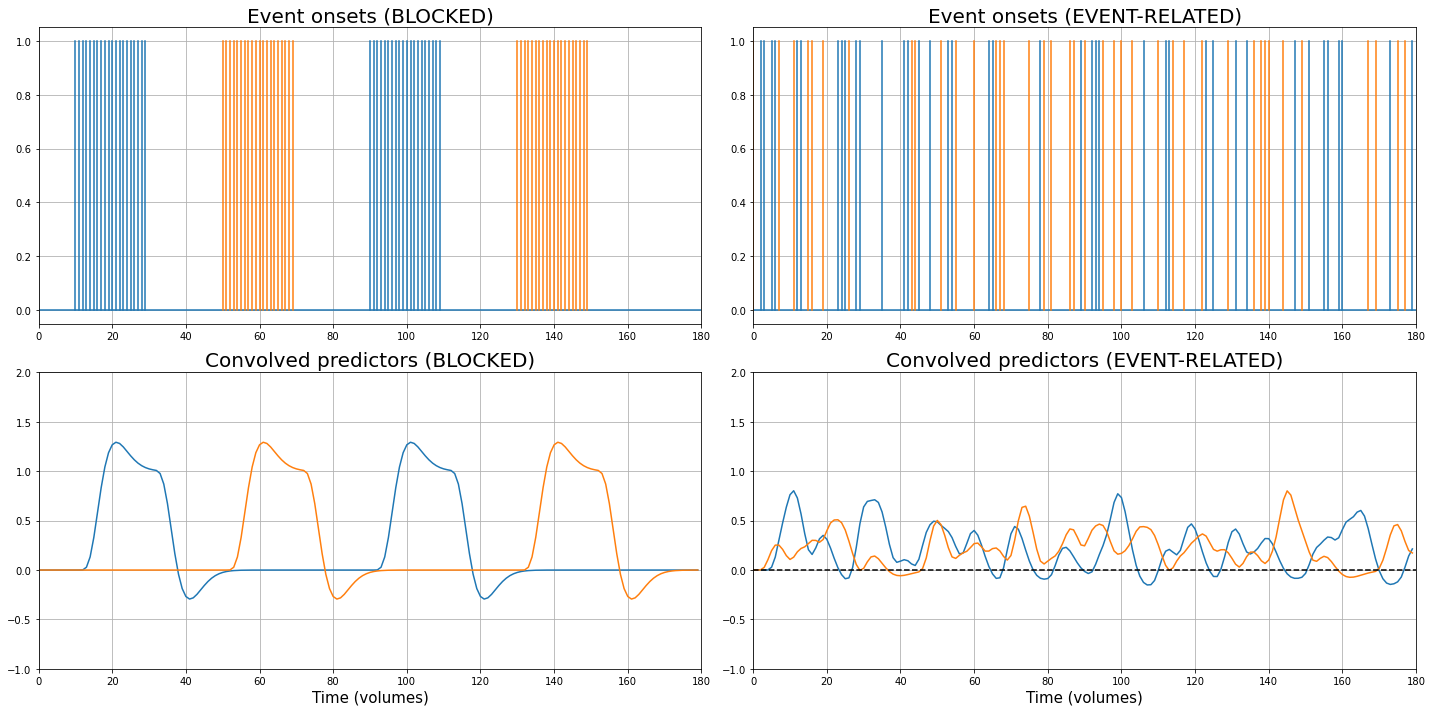

In [28]:
np.random.seed(2)

N = 180
dg_hrf = glover_hrf(tr=1, oversampling=1)

blocked_pred1_onsets = list(range(10, 30)) + list(range(90, 110))
blocked_pred2_onsets = list(range(50, 70)) + list(range(130, 150))
N_stim = len(blocked_pred1_onsets)
blocked_pred1, blocked_pred2 = np.zeros(N), np.zeros(N)
blocked_pred1[blocked_pred1_onsets] = 1
blocked_pred2[blocked_pred2_onsets] = 1

icept = np.ones((N, 1))
X_blocked = np.hstack((
    icept,
    np.convolve(blocked_pred1, dg_hrf)[:N, np.newaxis],
    np.convolve(blocked_pred2, dg_hrf)[:N, np.newaxis]
))

plt.figure(figsize=(20, 10))

plt.subplot(2, 2, 1)
plt.title("Event onsets (BLOCKED)", fontsize=20)
plt.xlim(0, N)
plt.axhline(0, c='tab:blue')
plt.grid()

for onset in blocked_pred1_onsets:
    plt.plot((onset, onset), (0, 1), c='tab:blue')

for onset in blocked_pred2_onsets:
    plt.plot((onset, onset), (0, 1), c='tab:orange')
    
plt.subplot(2, 2, 3)
plt.xlim(0, N)
plt.title("Convolved predictors (BLOCKED)", fontsize=20)
plt.ylim(-1, 2)
plt.plot(X_blocked[:, 1], c='tab:blue')
plt.plot(X_blocked[:, 2], c='tab:orange')
plt.grid()
plt.xlabel("Time (volumes)", fontsize=15)

er_stims = np.arange(N)
er_pred1_onsets = np.random.choice(er_stims, N_stim, replace=False)
er_stims_new = np.array([o for o in er_stims if o not in er_pred1_onsets])
er_pred2_onsets = np.random.choice(er_stims_new, N_stim, replace=False)
er_pred1, er_pred2 = np.zeros(N), np.zeros(N)
er_pred1[er_pred1_onsets] = 1
er_pred2[er_pred2_onsets] = 1

plt.subplot(2, 2, 2)
plt.xlim(0, N)
plt.title("Event onsets (EVENT-RELATED)", fontsize=20)
plt.axhline(0, c='tab:blue')
plt.grid()

for onset in er_pred1_onsets:
    plt.plot((onset, onset), (0, 1), c='tab:blue')

for onset in er_pred2_onsets:
    plt.plot((onset, onset), (0, 1), c='tab:orange')

X_er = np.hstack((
    icept,
    np.convolve(er_pred1, dg_hrf)[:N, np.newaxis],
    np.convolve(er_pred2, dg_hrf)[:N, np.newaxis]
))

plt.subplot(2, 2, 4)

plt.title("Convolved predictors (EVENT-RELATED)", fontsize=20)
plt.ylim(-1, 2)
plt.plot(X_er[:, 1], c='tab:blue')
plt.plot(X_er[:, 2], c='tab:orange')
plt.axhline(0, ls='--', c='k')
plt.xlim(0, N)
plt.grid()
plt.xlabel("Time (volumes)", fontsize=15)

plt.tight_layout()
plt.show()

As you can see in the plot above, a blocked design groups trials of the same condition together in blocks, while the event-related design is completely random in the sequence of trials. Note that designs can of course also be a "mixture" between blocked and event-related (e.g., largely random with some "blocks" in between).

So, if we're interested in detection (i.e., the amplitude of the response), what should we choose? 
Well, the answer is simple: **blocked designs**. 

This is because blocked designs simply (almost always) have lower design variance because of:
- lower covariance ("correlation")
- higher variance ("spread")

Let's check this for the designs from the plot. First, we'll look at the predictor covariance, but because predictor correlation is often more interpretable (correlation = standardized covariance), we'll calculate that instead:

In [29]:
corr_blocked = pearsonr(X_blocked[:, 1], X_blocked[:, 2])
corr_er = pearsonr(X_er[:, 1], X_er[:, 2])
print("Correlation blocked: %.3f. Correlation event-related: %.3f" % (corr_blocked[0], corr_er[0]))

Correlation blocked: -0.234. Correlation event-related: -0.284


<b>But what abour predictor variance?</b>
    
We've seen that predictor correlation is lower in blocked designs than in event-related designs. But what about predictor variance?

Let's calculate predictor variance for predictor 1 (column 2) and predictor 2 (column 3) for both the blocked design (<tt>X_blocked</tt>) and the event-related design (<tt>X_er</tt>).

Remember: (sample) variance is the summed squared deviation of values from a variable's mean divided by the number of observations minus 1, or formally:

\begin{align}
\mathbf{var}[x] = \frac{1}{N - 1}\sum_{i=1}^{N}(x - \bar{x})^{2}
\end{align}

We will store the variance of the four predictors (2 predictions $\times$ 2 designs) in the following variables:

- <tt>blocked_pred1_var</tt>
- <tt>blocked_pred2_var</tt>
- <tt>er_pred1_var</tt>
- <tt>er_pred2_var</tt>

Note: We will not **not** use the numpy function <tt>np.var</tt> for this (also because it's going to give us the wrong answer).

In [30]:

def variance(x):
    return ((x - x.mean()) ** 2).sum() / (x.size - 1)

blocked_pred1_var = variance(X_blocked[:, 1])
blocked_pred2_var = variance(X_blocked[:, 2])
er_pred1_var = variance(X_er[:, 1])
er_pred2_var = variance(X_er[:, 2])


print(blocked_pred1_var,blocked_pred2_var,er_pred1_var,er_pred2_var)

0.21202110388243742 0.21202099143501266 0.05352018671845568 0.03220994128469804



<b>Linear scaling of the BOLD-response improves block designs</b>: As we saw in tutorial (`05_GLM_part2_fMRI.ipynb`), the BOLD-response is assumed to scale linearly with added events. This has an effect in generating higher predictor variance, which becomes especially clear in blocked designs.


#### Balancing design 
As you've seen, blocked designs have larger predictor variance and (everything else being equal) are more efficient. In fact, up to a certain point, the larger the blocks of trials, the more efficient the design. This may, at first sight, reflect idea in most psychological research that more trials (events) lead to more power.

In fMRI designs, however, this is *not* the case, because at a certain point, longer blocks yield a *less* efficient design. Below, we define a function that simulates a single predictor for a blocked-design with a variable amount of trials in it (for a fixed experiment duration of 500 seconds and a TR of 1). So, for example, if we call the function with <tt>trials=10</tt>, it will create a design and predictor with a block of 10 consecutive stimuli (all lasting a second). We'll also plot the predictor after simulating the data. 

Now, suppose I would like to evaluate the contrast of that single predictor against baseline. In the text-cell below, argue why adding more trials does not necessarily mean a more efficient design, assuming some fixed length of the experiment.


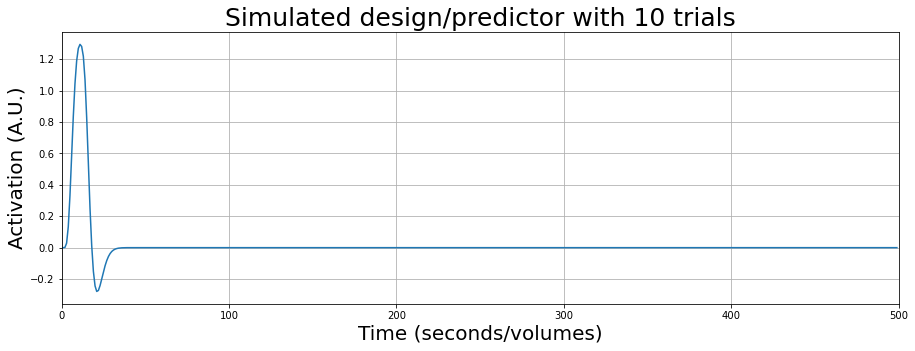

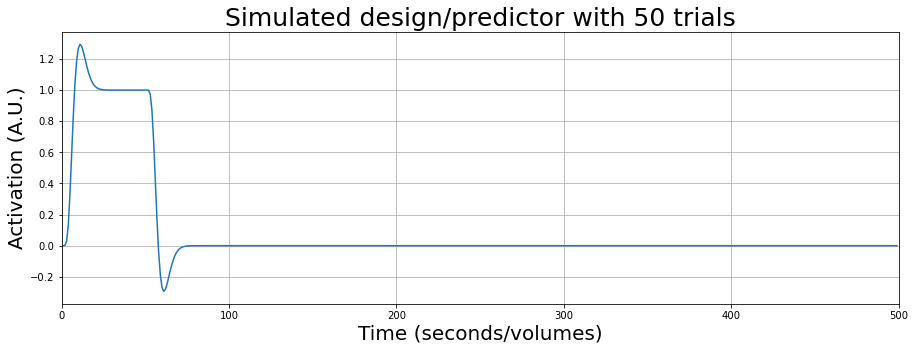

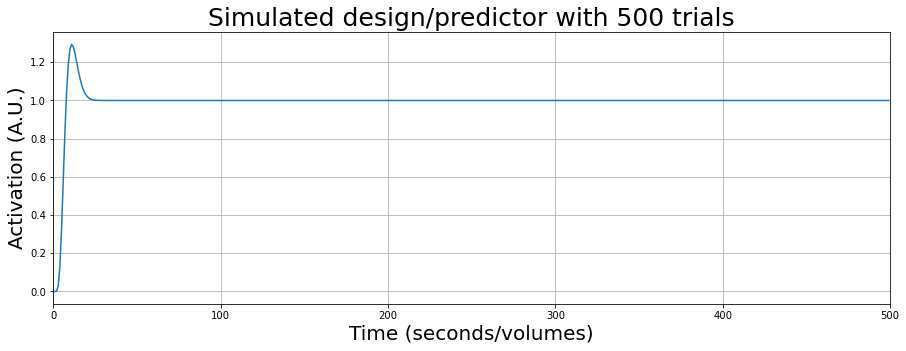

In [31]:
def simulate_single_predictor(trials, time_exp=500):

    if trials > time_exp:
        raise ValueError("Cannot have more trials than timepoints!")

    pred = np.zeros(time_exp)
    onsets = np.arange(trials) 
    pred[onsets] = 1
    dg = glover_hrf(tr=1, oversampling=1)
    pred_conv = np.convolve(pred, dg)[:time_exp, np.newaxis]
    X = np.hstack((np.ones((time_exp, 1)), pred_conv))
    return X

# We'll call the function above here:
contrast = np.array([0, 1])

# you can change this variable to investigate the effect of increasing/decreasing the amount of trials
N_TRIALS = 10
X = simulate_single_predictor(trials=N_TRIALS)

# ... and plot the predictor
plt.figure(figsize=(15, 5))
plt.plot(X[:, 1])
plt.xlim(0, 500)
plt.title("Simulated design/predictor with %i trials" % N_TRIALS, fontsize=25)
plt.xlabel("Time (seconds/volumes)", fontsize=20)
plt.ylabel("Activation (A.U.)", fontsize=20)
plt.grid()
plt.show()


N_TRIALS = 50
X = simulate_single_predictor(trials=N_TRIALS)

# ... and plot the predictor
plt.figure(figsize=(15, 5))
plt.plot(X[:, 1])
plt.xlim(0, 500)
plt.title("Simulated design/predictor with %i trials" % N_TRIALS, fontsize=25)
plt.xlabel("Time (seconds/volumes)", fontsize=20)
plt.ylabel("Activation (A.U.)", fontsize=20)
plt.grid()
plt.show()

N_TRIALS = 500
X = simulate_single_predictor(trials=N_TRIALS)

# ... and plot the predictor
plt.figure(figsize=(15, 5))
plt.plot(X[:, 1])
plt.xlim(0, 500)
plt.title("Simulated design/predictor with %i trials" % N_TRIALS, fontsize=25)
plt.xlabel("Time (seconds/volumes)", fontsize=20)
plt.ylabel("Activation (A.U.)", fontsize=20)
plt.grid()
plt.show()

The efficiency of the design, in principle, does not depend on the number trials directly, but only its variance and covariance (here: only variance, because we only have one predictor). If we use a lot of trials, our BOLD-response saturates and will be *constantly* high, and thus have low variance and consequently low design efficiency! Conceptually, this decreases the efficiency/power of our design, because the effect of our stimulus becomes indistinguishable from baseline, because if we're constantly stimulating the brain, the stimulation *becomes* the baseline!

### The "paradox" of efficiency
So, we've discussed blocked and event-related designs and we've come to the conclusion that blocked designs are simply more efficient than event-related designs. "So, we should always use blocked designs?", you may ask. 

Well, no.

We've discussed the mathematics behind design variance, efficiency, and t-value in detail, but we shouldn't forget that ultimately **we're measuring the data from a living human beings in the MRI-scanner**, who tend to get bored, fall asleep, and otherwise not pay attention if the task they're doing is monotonous, predictable or simply uninteresting!

Blocked designs, however, are (usually) exactly this: designs that are experienced as predictable, monotonous, and (relatively) boring! Like we said earlier, the effects we're going to measure depend on three things - effects, noise, and design efficiency - and psychological factors may strongly influence the "effect" part and thus affect the statistics we're interested in (i.e., t-values). In addition to psychological factors like boredom and inattention, blocked designs may also lead to unwanted effects like habituation (attenuation of the BOLD-response after repeated stimulation), which violate the assumption of the BOLD-response as being 'linear time-invariant' (LTI). In other words, the BOLD-response may stop 'behaving' like we assume it behaves when we use blocked designs.

This is, essentially, the paradox of designing fMRI experiments: the most efficient designs are also the designs that (potentially) lead to the lowest signal or otherwise unintended effects (due to boredom, predictability, habituation, etc.).

So, what do we do in practice? Usually, we use (semi-random) event-related designs. We lose some efficiency by using event-related designs instead of blocked designs, but we reduce the chance of psychological factors and other effects that reduce the measured signal or mess with the assumption of linear time-invariance.

Given that we're going to use some event-related (i.e., "random") design, let's investigate how we can optimize this type of design.

### Improving design efficiency for event-related designs using jittering
Usually, events in an experimental design are separated by short periods without any event; this is called the "inter-stimulus interval" (ISI; also called stimulus onset asynchrony, SOA) - the time between successive stimuli. For example, the experiment from the image below has an ISI of 50 seconds:

![img](https://docs.google.com/drawings/d/e/2PACX-1vQwC4chpnzsDEzKhrKH_WHhMX7vJswY4H0pkyIxdlxI_I2GG5e8i6lsiWUO0SUk7NBgdV-vXD5PIleJ/pub?w=950&h=397)


Let's simulate some event-onsets and predictors for this experiment. We have two predictors (circles and squares). The stimuli ('events') take 1 second and the ISI is 8 seconds (more realistic than the figure above). Suppose we're interested in both contrasts against baseline (circles against baseline; squares against baseline).

Now, let's simulate one design (with a fixed ISI), calculate efficiency and plot it:

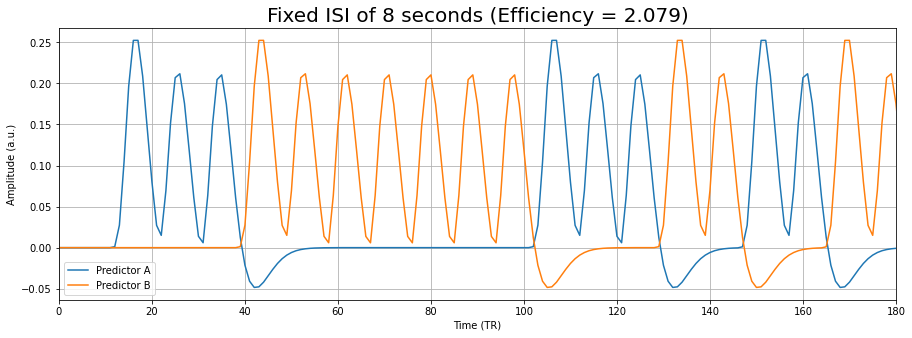

In [32]:
def simulate_data_fixed_ISI(N=420):

    dg_hrf = glover_hrf(tr=1, oversampling=1)
    
    # Create indices in regularly spaced intervals (9 seconds, i.e. 1 sec stim + 8 ISI)
    stim_onsets = np.arange(10, N - 15, 9)
    stimcodes = np.repeat([1, 2], stim_onsets.size / 2)  # create codes for two conditions
    np.random.shuffle(stimcodes)  # random shuffle
    stim = np.zeros((N, 1))

    c = np.array([[0, 1, 0], [0, 0, 1]])

    # Fill stim array with codes at onsets
    for i, stim_onset in enumerate(stim_onsets):
        stim[stim_onset] = 1 if stimcodes[i] == 1 else 2
    
    stims_A = (stim == 1).astype(int)
    stims_B = (stim == 2).astype(int)

    reg_A = np.convolve(stims_A.squeeze(), dg_hrf)[:N]
    reg_B = np.convolve(stims_B.squeeze(), dg_hrf)[:N]
    X = np.hstack((np.ones((reg_B.size, 1)), reg_A[:, np.newaxis], reg_B[:, np.newaxis]))
    
    # Calculate design variance
    dvars = [(c[i, :] @ inv(X.T @ X) @ (c[i, :].T)) for i in range(c.shape[0])]        
    # Calculate design efficiency         
    eff = c.shape[0] / np.sum(dvars)
    return X, eff

X, eff = simulate_data_fixed_ISI()
plt.figure(figsize=(15, 5))    
plt.title('Fixed ISI of 8 seconds (Efficiency = %.3f)' % eff, fontsize=20)
plt.plot(X[:, 1])
plt.plot(X[:, 2])
plt.legend(['Predictor A', 'Predictor B'])
plt.ylabel('Amplitude (a.u.)')
plt.xlabel('Time (TR)')
plt.xlim(0, N)
plt.grid()
plt.show()

Often, though, researchers do not use a *fixed* ISI, but they vary the ISI from trial to trial. This process is called "jittering". Usually, the ISIs are drawn randomly from a known distribution (e.g., truncated exponential or normal distribution). Compared to using fixed ISIs, jittering may yield more efficient designs by reducing covariance and increasing predictor variance. Let's simulate another dataset, but this time with a variable ISI between 2-6 seconds (which is on average 4 seconds, but variable across trials):

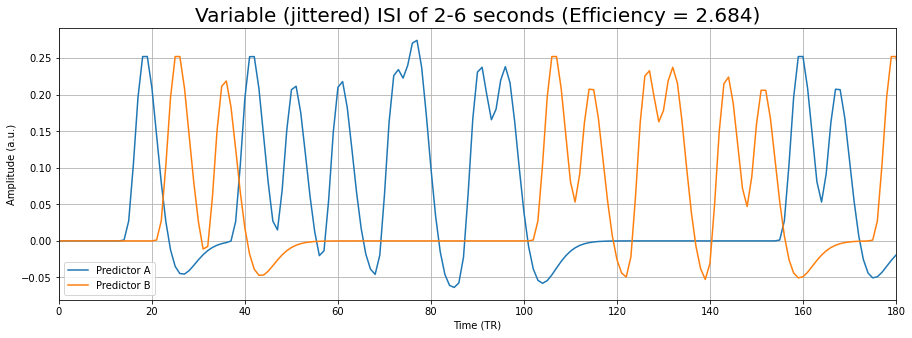

In [33]:
def simulate_data_jittered_ISI(N=420):
    
    dg_hrf = glover_hrf(tr=1, oversampling=1)
    
    stim_onsets = np.arange(10, N - 15, 9)
    stimcodes = np.repeat([1, 2], stim_onsets.size / 2)
    np.random.shuffle(stimcodes)

    # Here, we pick some *deviations* from the standard ISI (i.e., 8),
    # so possible ISIs are (8 - 2, 8 - 1, 8 - 0, 8 + 1, 8 + 2)
    ISIs = np.repeat([-2, -1, 0, 1, 2], repeats=11)
    np.random.shuffle(ISIs)
    
    stim = np.zeros((N, 1))
    c = np.array([[0, 1, 0], [0, 0, 1]])

    for i, stim_onset in enumerate(stim_onsets):
        # We subtract the stim-onset with -2, -1, 0, 1, or 2 (from ISIs)
        # to simulate jittering
        stim[stim_onset - ISIs[i]] = 1 if stimcodes[i] == 1 else 2
        
    stims_A = (stim == 1).astype(int)
    stims_B = (stim == 2).astype(int)
    reg_A = np.convolve(stims_A.squeeze(), dg_hrf)[:N]
    reg_B = np.convolve(stims_B.squeeze(), dg_hrf)[:N]
    X = np.hstack((np.ones((reg_B.size, 1)), reg_A[:, np.newaxis], reg_B[:, np.newaxis]))

    # Calculate design variance
    dvars = [(c[i, :] @ inv(X.T @ X) @ (c[i, :].T)) for i in range(c.shape[0])]  
    # Calculate design efficiency  
    eff = c.shape[0] / np.sum(dvars)
    return X, eff

plt.figure(figsize=(15, 5))    
X, eff = simulate_data_jittered_ISI()
plt.title('Variable (jittered) ISI of 2-6 seconds (Efficiency = %.3f)' % eff, fontsize=20)
plt.plot(X[:, 1])
plt.plot(X[:, 2])
plt.legend(['Predictor A', 'Predictor B'])
plt.ylabel('Amplitude (a.u.)')
plt.xlabel('Time (TR)')
plt.xlim(0, N)
plt.grid()
plt.show()

As you can see in the plot above, jittering improved design efficiency quite a bit! It is important to realize that jittering does not *always* improve design efficiency, but by "injecting" randomness (by selecting semi-random ISIs) it allows for *a larger variety* of designs, which also include designs that happen to be more efficient than the fixed-ISI designs. 


<b>Optimising design</b>

In the previous two examples (fixed-ISI and jittered ISI examples), we saw that the fixed-ISI design was less efficient than the jittered ISI design. In general, jittering increases the number of different designs you can simulate relative to fixed-ISI designs. A great way to visualize this is to simply run the simulation of fixed-ISI and jittered-ISI designs a number of times and plot the resulting efficiencies in two separate histograms. You should see that the histogram of efficiencies from fixed-ISI designs is quite a bit narrower than the histogram of efficiencies from jittered-ISI designs (but you might also also see that some jittered-ISI designs are *less* efficient that the average fixed-ISI design).

So, in this illustration, we will call the two simulation-functions (<tt>simulate_data_jittered_ISI</tt> and <tt>simulate_data_fixed_ISI</tt>) each 1000 times (use <tt>N=420</tt>, the default value) and keep track of the efficiency from both. Then, we will plot in *a single plot*, the histogram (using <tt>plt.hist</tt>) of the fixed-ISI efficiencies and the histogram of the jittered-ISI efficiencies. 


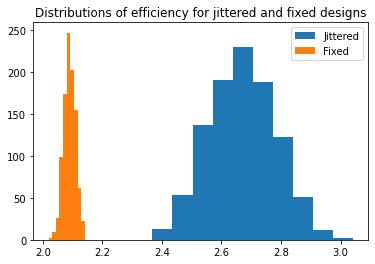

In [34]:

iterations = 1000

#initialize variables
eff_fixed = np.zeros(iterations)
eff_jittered = np.zeros(iterations)
# Make a loop for simulations
for i in range(iterations):
    #Run functions from previous cells
    eff_fixed[i] = simulate_data_fixed_ISI(N=420)[1]
    eff_jittered[i] = simulate_data_jittered_ISI(N=420)[1]

#Plot histogram
plt.hist(eff_jittered, bins=10)
plt.hist(eff_fixed, bins=10)
plt.legend(['Jittered', 'Fixed'])
plt.title("Distributions of efficiency for jittered and fixed designs")
plt.show()


### Summary: how to optimize your design for efficiency
So, in this section we discussed how to structure your experiment such that it yields a (relatively) high design efficiency, which will optimize our chance to find significant effects. How you do this depends on whether you aim for estimation (what is the shape of the HRF?) or for detection (what is the amplitude of the response?). Usually, we aim for detection; in that case, designs can be roughly grouped in two types: blocked designs an event-related designs. Purely statistically speaking, blocked designs are (almost always) more efficient, because they generally have lower covariance and higher variance than event-related designs. However, due to psychological factors and potential violations of the linear time-invariance of the BOLD-response, we often opt for event-related designs in the end. For event-related designs, we can increase our chance of finding a relatively efficient design by jittering our ISIs. We can even simulate different designs and pick the most efficient.


<div class='alert alert-success'>
    
    
<b>SOLUTIONS</b>
    
    
</div>



<div class='alert alert-warning'>
    <b>Solution for ToDo1</b>:
</div>

In [36]:
from numpy.linalg import inv

### BEGIN SOLUTION
betas_todo = inv(X.T @ X) @ X.T @ y

### END SOLUTION
#If you get an error for this, it may be becasue you have run it outside it's context. Copy/paste it into the cell under ToDo1. If you already ran the subsequent cells, restart and run from beginning.

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 160 is different from 420)

<div class='alert alert-info'>
    <b>Solution to ToThink1</b>:
</div>

The positive parameter of the unmodulated predictor tells use that this voxel increases in activity in response to reward events, regardless of reward magnitude. On top of the "common" response, the positive parameter of the modulated predictor tells us that the voxel increases more in activity for reward events with higher magnitude rewards relative to lower reward magnitudes.


<div class='alert alert-success'>
    
    
<b>END OF SOLUTIONS</b>
    
    
</div>